# Pump and Treat - Well System Model

![River Base Concept Model](river_and_wells.svg)

# Example description
### Spatial configuration
There is two simulated aquifer which are separated by an aquitard. The model grid consists of 15 rows, 10 columns, and 3 layers.  Uniform grid spacing with a row and column width of 100.0 meters. The top layer is positioned at an elevation of 15.0 meters, while the bottom layers are situated at elevations of -5.0, -10.0, and -15.0 meters, respectively.
### Temporal discretization
The model is designed for a simulation period of 10 days, divided into 120 time steps per stress period, with a time step multiplier of 1.0. The simulation is repeated for a total of 3 periods. The model operates in days as time units and meters as length units.
### Layer Hydraulic properties 
Initial hydraulic conductivity values for the three layers are set at 0.5, 0.000006, and 0.5, respectively.
The vertical anisotropy ratios for the layers are specified as 0.1, 0.2, and 0.3, indicating differences in hydraulic conductivity in the vertical direction.
### Storage properties 
The specific yield is set at 0.2, representing the volumetric ratio of water that drains under the influence of gravity.The specific storage is specified as 0.000001, representing the compressibility of the aquifer.
### Boundary Conditions 
The model starts with an initial hydraulic head of 10.0 meters across the entire domain. 
Two constant head boundaries are established at specific locations: one at the intersection of the first layer, first row, and first column and another at the intersection of the last layer, last row, and last column, each set at a constant head of 10.0 meters.
### Solute transport conditions 
The initial concentration of the substance being transported within the groundwater system set to 1.
The model simulates a point source contamination: at cell (Layer 0, Row 5, Column 1), the initial concentration is set to 10.
Similarly, at cell (Layer 0, Row 6, Column 1), the initial concentration is also set to 10.
### Well Boundary Conditions 
The 3 wells are located at (0, 4, 4), (0, 6, 4) and (0, 8,4); and all wells only reaching the first layer (=0). 
Discharge or pumping rates associated with the wells are -0.05 (m/d) on the first time-period, -0.5 for the second and -0.05 for the third.

# Start setting up the model 

### Magic commands - auto reload of the model each time 

In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
%autoreload 2

### Import from pymf6tools the functions to run, get and visualize simulation results

In [25]:
from pathlib import Path
import numpy as np 
from pymf6.mf6 import MF6
import pandas as pd 
from functools import partial 

from pymf6_tools.base_model import make_model_data
from pymf6_tools.make_model import make_input, run_simulation, get_simulation
from pymf6_tools.plotting import show_heads, show_well_head, show_bcs

In [26]:
from pymf6_tools.plotting import show_heads, show_well_head, show_concentration, show_bcs, show_bot_elevations, show_river_stages, contour_bot_elevations, plot_spec_discharge

## Set model path and name 

In [27]:
model_path = r'models/transbase'
model_name = 'transbase'

## Run simulation - Uncontrolled

In [28]:
run_simulation(model_path)

## Visualization of Input and Output - e.g. Boundary conditions and Heads 

### Plot Boundary conditions 

### Boundary Conditions 
Note that you should change the "bc_names" according to the boundary conditions present in the simulation.  
<span style="color:blue">'chd'</span> Constant-head boundary  
<span style="color:blue">'wel'</span> River boundary

In [29]:
show_bcs?

Signature:
show_bcs(
    model_path,
    name,
    title='Boundary Conditions',
    bc_names=('chd', 'wel', 'riv'),
    show_grid=True,
)
Docstring: Show location of boundary conditions.
File:      c:\users\lucialabarca\pymf6-validation\.pixi\envs\default\lib\site-packages\pymf6_tools\plotting.py
Type:      function

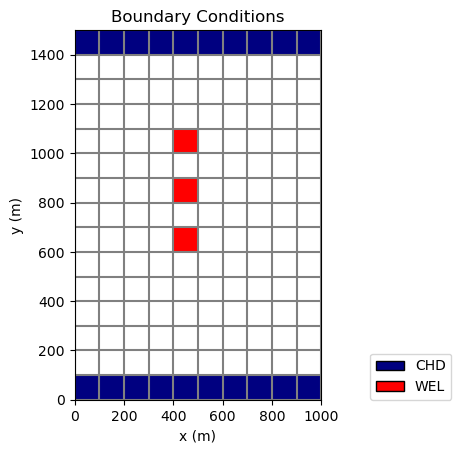

In [30]:
show_bcs(model_path, model_name, bc_names=('chd','wel'))

### Specific Discharge - Interactive graph (layer and time)
Specify the layer and time of the simulation to be visualized.

In [31]:
plot_spec_discharge(model_path, model_name, layer=1, times = 300)

ValueError: datafile error: file is empty: C:\Users\lucialabarca\pymf6-validation\src\notebooks\models\transbase\gwf_transbase.bud

In [32]:
plot_spec_discharge(model_path, model_name, layer=2, times = 300)

ValueError: datafile error: file is empty: C:\Users\lucialabarca\pymf6-validation\src\notebooks\models\transbase\gwf_transbase.bud

### Groundwater level 

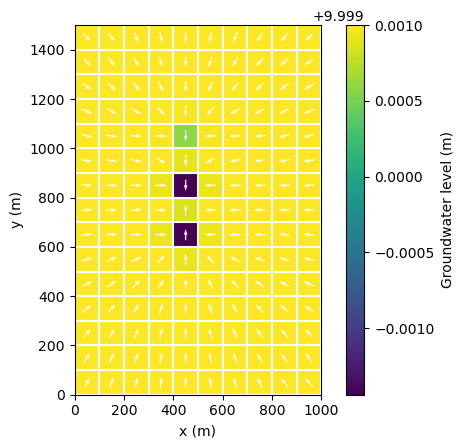

In [21]:
show_heads(model_path, model_name, show_wells=False)

### Visualize contamination plume

### Concentration

Exception: ftype not specified

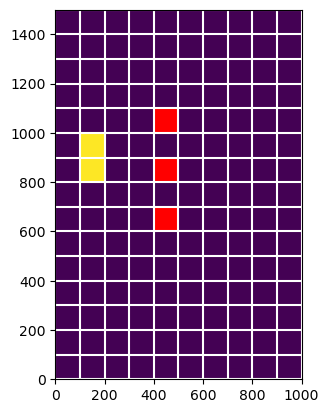

In [22]:
show_concentration(model_path, model_name, show_wells=True, show_arrows=True)

## pmyf6 dynamic control 

### Controlled case 

The technical objective is to dynamically regulate the pumping rates of these wells during the simulation based on two key thresholds: the daily treatment capacity (i.e., a maximum allowable extracted volume) and the contaminant concentrations at the municipal boundary, in order to maintain water quality the aquifer located at the protected area. The contamination source was implemented using the Initial Conditions (IC) package, with initial concentration of 10.0 defined at two grid cells: (1, 6, 2) and (1, 7, 2). To track contaminant migration and evaluate the performance of the hydraulic barrier, an observation well was installed on the eastern (right) side of the model at the municipal boundary, at coordinates (1, 6, 7). The extraction wells that form the hydraulic barrier are located at (1, 5, 5), (1, 7, 5), and (1, 9, 5), strategically positioned between the contamination source  and area we want to protect. 

### Inspect visualization tools

In [ ]:
show_bcs?

### Inspect the parameters by importing the model results 

In [ ]:
mf6 = MF6(model_path)

In [24]:
mf6.models.keys()

dict_keys(['gwt6', 'gwf6'])

In [33]:
gwf_models = mf6.models['gwf6']

In [34]:
gwf_models.keys()

dict_keys(['gwf_transbase'])

In [35]:
gwt_models = mf6.models['gwt6']

In [36]:
gwt_models.keys()

dict_keys(['gwt_transbase'])

### Inspect model packages 

In [37]:
gwt = gwt_models['gwt_transbase']

In [39]:
gwf = gwf_models['gwf_transbase']

In [40]:
gwf.packages

,description,is_mutable
name,,
dis,DIS Package: DIS,False
mvr,MVR Package: MVR,True
wel-1,WEL Package: WEL-1,True
vsc,VSC Package: VSC,True
chd-1,CHD Package: CHD-1,True
buy,BUY Package: BUY,True
ic,IC Package: IC,False
gnc,GNC Package: GNC,True
sto,STO Package: STO,False


In [31]:
gwt.packages

,description,is_mutable
name,,
dis,DIS Package: DIS,False
mst,MST Package: MST,False
mvt,MVT Package: MVT,True
adv,ADV Package: ADV,True
dsp,DSP Package: DSP,False
ssm,SSM Package: SSM,True
ic,IC Package: IC,False
cnc_0,CNC Package: CNC_0,True
fmi,FMI Package: FMI,True


### Controlled Well Head 

### Run the control script 